# Struct2XAS examples: from CIF/XYZ to XANES/EXAFS simulations with FDMNES and FEFF

- Authors: Beatriz G. Foschiani and Mauro Rovezzi
- Contact: mauro.rovezzi@esrf.fr
- Last modified: September 2023

Here we provide various examples on the usage of `larch.xrd.struct2xas` module.

In [1]:
import os
import larch

## Example 1: Zn K-edge XANES of wurtzite ZnO with FDMNES from a CIF file

This example shows how to use the `Struct2XAS` class to convert a CIF file to a FDMNES XANES input. We will simulate Zn K-edge XAS of ZnO. 

- The input structure is taken from the Materials Project database: [mp-2133](https://legacy.materialsproject.org/materials/mp-2133/).
- The experimental data are taken from the SSHADE/FAME database: [DOI:10.26302/SSHADE/EXPERIMENT_ST_20180418_001](https://www.sshade.eu/data/EXPERIMENT_ST_20180418_001)

Import the main class and instantiate it with the CIF file and the name of the absorbing element

In [2]:
from larch.xrd.struct2xas import Struct2XAS
mat_obj = Struct2XAS(file = "../structuredata/struct2xas/ZnO_mp-2133.cif", abs_atom="Zn")

[struct2xas] INFO : Frames: 1, Absorbing sites: 1. (Indexes for frames and abs_sites start at 0)


to get the information about absorbing site

In [3]:
# information about absorbing site as pandas.DataFrame
mat_obj.get_abs_sites_info()

the same, more programmatically

In [4]:
mat_obj.get_abs_sites()

[[0,
  'Zn',
  [0.3333, 0.6667, 0.4995],
  '2b',
  array([-1.6446,  0.9495, -2.6505]),
  1,
  0]]

Getters and setters are available for changing the absorber site being considered. We can use the methods `set_abs_site` and `get_abs_site`. This structure has only one absorber site (an example with multiple sites is given later).

In [5]:
mat_obj.set_abs_site(0)

to get information on the coordination environment around absorber atom

In [6]:
mat_obj.get_coord_envs_info()

Coord. Env. from absorber atom: Zn at site 0
['T:4', 'T:5']


Element  Distance
0     (O)   2.00418
1     (O)   2.00425
2     (O)   2.00426
3     (O)   2.01242
4     (O)   3.29440

or programmatically

In [7]:
mat_obj.get_coord_envs()


[['Coord. Env. for Site 0',
  [{'ce_symbol': 'T:4',
    'ce_fraction': 0.8596848561093451,
    'csm': 0.00569144245172932,
    'permutation': [0, 1, 2, 3]},
   {'ce_symbol': 'T:5',
    'ce_fraction': 0.1403151438906549,
    'csm': 4.062381866591053,
    'permutation': [0, 1, 4, 2, 3]}],
  [{'site': PeriodicNeighbor: O3 (O) (-3.289, 1.899, -3.291) [0.6667, 1.333, 0.6202],
    'index': 3,
    'image_cell': array([0, 1, 0])},
   {'site': PeriodicNeighbor: O3 (O) (-6.423e-07, 1.899, -3.291) [-0.3333, 0.3333, 0.6202],
    'index': 3,
    'image_cell': array([-1,  0,  0])},
   {'site': PeriodicNeighbor: O2 (O) (-1.645, 0.9495, -0.6381) [0.3333, 0.6667, 0.1202],
    'index': 2,
    'image_cell': array([0, 0, 0])},
   {'site': PeriodicNeighbor: O3 (O) (-1.645, -0.9495, -3.291) [0.6667, 0.3333, 0.6202],
    'index': 3,
    'image_cell': array([0, 0, 0])},
   {'site': PeriodicNeighbor: O2 (O) (-1.645, 0.9495, -5.945) [0.3333, 0.6667, 1.12],
    'index': 2,
    'image_cell': array([0, 0, 1])}]]]

It is possible to visualize the local environment at a ginen radius from the absorber

In [8]:
mat_obj.visualize(radius=2.5)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[struct2xas] INFO : {'Zn': 'red', 'O': 'green'}


To create the FDMNES input file using the default template in a temporary directory

In [9]:
mytemplate = None #: uses default FDMNES XANES template (-> `larch/xrd/templates/fdmnes.tmpl`)
mypath = None #: creates a default structure -> "mydir/fdmnes/input_structure/abs_atom/siteN/"
mat_obj.make_input_fdmnes(radius=7, green=False, template=mytemplate, parent_path=mypath)

[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/fdmnes/ZnO_mp-2133/Zn/frame0/site0/job_inp.txt


To show the created input file

In [10]:
! cat {mat_obj.outdir}/job_inp.txt

! FDMNES input file generated by Struct2XAS

header

comment
cif file name: ZnO_mp-2133
creation date:2023-09-30_1618

filout

job

range
-30.0 0.1 70.0 1.0 100 

radius
7

quadrupole

density

SCF



absorber
1

spgroup
186



crystal
3.28910248     3.28910248   5.30682100  90.00000000  90.00000000 120.00000000

30   0.33333333   0.66666667   0.49945200   Zn
 8   0.33333333   0.66666667   0.12023800    O

convolution

end


Run FDMNES (refer to FDMNES documentation if needed)

```python
#Example how to run FDMNES at the ESRF via SLURM 
input = mat_ojb.parent_path
! cd {input}; subfdmnes -c 30
```

The output files created by FDMNES will be:
- `job.txt`: non-convoluted spectra
- `job_conv.txt`: convoluted spectra (by fdmnes with default parameters)
- `job_out.txt`: FDMNES output during the execution of the program (NOTE: this is created by the SLURM submission script)
- `job_sd0.txt`: file with the projected density of states information
- `job_bav.txt`: file with large simulation infos (better to compress it or remove)

Please, refer to [XANES_Convolution.ipynb](./XANES_Convolution.ipynb) for a comparison of the simulated data with experimental one.

## Example 1a: Zn K-edge EXAFS with FEFF

We can also simulate the EXAFS spectrum with FEFF

In [11]:
mytemplate = None #: uses default FEFF EXAFS template (-> `larch/xrd/templates/feff_exafs.tmpl`)
mypath = mat_obj.parent_path #: if None creates a default structure -> "mydir/feff/input_structure/abs_atom/frameN/siteN/"
mat_obj.make_input_feff(radius=7, template=mytemplate, parent_path=mypath)

[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/ZnO_mp-2133/Zn/frame0/site0/feff.inp


to show the input file

In [12]:
! cat {mat_obj.outdir}/feff.inp

* FEFF8* input file generated by Struct2XAS

TITLE ZnO_mp-2133
TITLE 2023-09-30_1618
TITLE site 0

*  <central> <edge> edge energy = <eedge> eV
EDGE      K
S02       0.0

*         pot    xsph  fms   paths genfmt ff2chi
CONTROL   1      1     1     1     1      1
PRINT     1      0     0     0     0      0

*** ixc=0 means to use Hedin-Lundqvist
*         ixc  [ Vr  Vi ]
EXCHANGE  0

*         r_scf  [ l_scf   n_scf   ca ]
*SCF       5.0

RPATH     7
EXAFS     20
NLEG      6

* EXAFS damping, to mimic the structural disorder
* SIG2 0.005

* Debye-Waller factors
* DEBYE 0 0

*         emin  emax   eimag
*LDOS      -30   20     0.1


POTENTIALS

* ipot  Z   tag [lmax1 lmax2 xnatph sphinph]
    0  30 Zn(abs)
    2   8     O
    1  30    Zn 

ATOMS

*   x          y          z     ipot   tag    distance   occupancy
  0.000048  -0.000018  -0.000002 0  Zn(abs)    0.00000         *1 
 -1.644504   0.949464  -0.640992 2      O    2.00418         *1 
  0.000049  -1.898982  -0.640992 2      O    

run FEFF

In [13]:
#via larch
from larch.xafs import FeffRunner
feff_inp = f"{mat_obj.outdir}/feff.inp"
sim = FeffRunner(feff_inp)
sim.run()

 : ======== running Feff module feff8l_rdinp ========
 : Feff8L (EXAFS)      release  0.1
 : ZnO_mp-2133
 : 2023-09-30_1618
 : site 0
 : ======== running Feff module feff8l_pot ========
 : Calculating potentials ...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : initial state energy
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : : ipot, Norman radius, Muffin tin radius, Overlap
 : 0  1.42792E+00  1.30600E+00  1.15000E+00
 : 1  1.41649E+00  1.30145E+00  1.15000E+00
 : 2  1.09462E+00  1.00452E+00  1.15000E+00
 : : mu_old=    -0.830
 : Done with module 1: potentials.
 : ======== running Feff module feff8l_xsph ========
 : Calculating cross-section and phases...
 : absorption cross secti

Note: can also be run via direct call to `feff8l`

```
! cd {mat_obj.parent_path}; feff8l
```

load the simulated EXAFS

In [14]:
from glob import glob
xmu = glob(f"{mat_obj.outdir}/xmu.dat")[0]
from larch.io import read_ascii
gsim = read_ascii(xmu, labels=["energy", "erel", "k", "mu", "mu0", "chi"])

Load experimental data and quickly extract the EXAFS signal

In [15]:
example_fn = os.path.join('..', "fdmnes", "ZnO_SSHADE.data.txt")
gexp = read_ascii(example_fn, labels=["energy", "mu"])
from larch.xafs import pre_edge, autobk
pre_edge(gexp, e0=9661)
autobk(gexp)

then plot

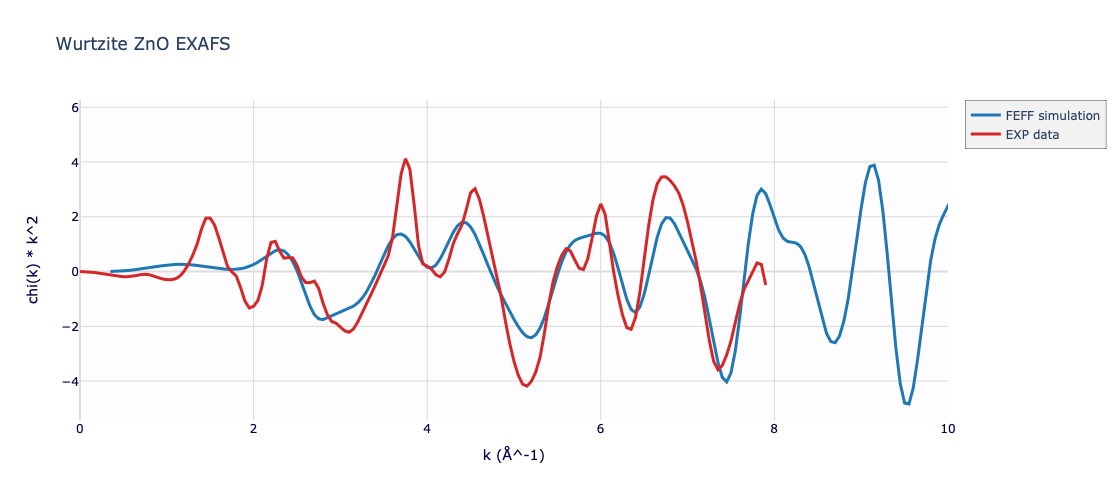

In [16]:
from larch.plot.plotly_xafsplots import PlotlyFigure
fig = PlotlyFigure()
fig.add_plot(gsim.k+0.3, gsim.chi*gsim.k**2, label="FEFF simulation")
fig.add_plot(gexp.k, gexp.chi*gexp.k**2, label="EXP data")

fig.set_style(title="Wurtzite ZnO EXAFS", width=800, height=500, xaxis_title="k (Å^-1)", yaxis_title="chi(k) * k^2" )
fig.set_xrange(0, 10)
fig.show()

*Note: the agreement is not very good because the experimental EXAFS data stops at 8 $\AA^{-1}$ and the structure parameters are not optimized.*

## Example 2: structures with multiple sites

Here an example when the input structure has multiple sites for a given absorbing element. The number of non-equivalent sites is found via the [SpaceGroupAnalyzer](https://pymatgen.org/pymatgen.symmetry.analyzer.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer) in Pymatgen, which is based on [Spglib](https://spglib.readthedocs.io/en/latest/).


In [17]:
from larch.xrd.struct2xas import Struct2XAS
cif_input_fn = os.path.join('..', "structuredata", "struct2xas", "ZnO_mp-997630.cif")
mat_obj = Struct2XAS(file=cif_input_fn, abs_atom="Zn")

[struct2xas] INFO : Frames: 1, Absorbing sites: 4. (Indexes for frames and abs_sites start at 0)


In [18]:
mat_obj.get_abs_sites_info()

it is possible to select one site and get information on the local environment and visualize, as shown before

In [19]:
# analysis for second site
mat_obj.set_abs_site(2)
print(mat_obj.get_coord_envs_info())
mat_obj.visualize()

Coord. Env. from absorber atom: Zn at site 2
['T:6']
  Element  Distance
0     (O)   2.21120
1     (O)   2.21120
2     (O)   2.21120
3     (O)   2.21124
4     (O)   2.21124
5     (O)   2.21124


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[struct2xas] INFO : {'Zn': 'red', 'O': 'green'}


to create the FDMNES inputs simply range over the sites

In [20]:
mypath = None
for site in range(mat_obj.nabs_sites): 
    mat_obj.set_abs_site(site)
    mat_obj.make_input_fdmnes(radius=7, green=False, parent_path=mypath)
    mypath = mat_obj.parent_path

[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/fdmnes/ZnO_mp-997630/Zn/frame0/site0/job_inp.txt
[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/ZnO_mp-997630/Zn/frame0/site1/job_inp.txt
[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/ZnO_mp-997630/Zn/frame0/site2/job_inp.txt
[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/ZnO_mp-997630/Zn/frame0/site3/job_inp.txt


and the FEFF inputs too

In [21]:
for site in range(mat_obj.nabs_sites): 
    mat_obj.set_abs_site(site)
    mat_obj.make_input_feff(radius=7, parent_path=mypath)

[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/ZnO_mp-997630/Zn/frame0/site0/feff.inp
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/ZnO_mp-997630/Zn/frame0/site1/feff.inp
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/ZnO_mp-997630/Zn/frame0/site2/feff.inp
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/ZnO_mp-997630/Zn/frame0/site3/feff.inp


## Example 3: grab CIFs from Materials Project

In this example some CIFs files are grabbed from the Materials Project database (MP) via a query and the inputs files are generated.

A personal API key is required to query the database (-> [here](https://legacy.materialsproject.org/open). *NOTE* the legacy version is used in this example, that is, the "old" version of MP. Export `your_api_key` to the environmental variable `MP_API_KEY`.



In [24]:
import os
from mp_api.client import MPRester
from larch.xrd.struct2xas import Struct2XAS, save_mp_structure, structure_folders

api_key = os.getenv("MP_API_KEY")
mpr = MPRester(api_key)

we search for materials containing 2 elements, Zn and O, plus further filter those IDs not present in the ICSD database

In [27]:
# criterias to query the materials

entries = mpr.summary.search(elements=["Zn", "O"], num_elements=[2, None])

#: skip materials not present in the ICSD database
mp_ids = [e.material_id for e in entries if 'icsd' in e.database_IDs]
                                           
print(f"Found {len(mp_ids)} structures")

Retrieving SummaryDoc documents:   0%|          | 0/3643 [00:00<?, ?it/s]

Found 827 structures


save the corresponding Structure files

In [28]:
for id in mp_ids[:10]:
    struct_fname = save_mp_structure(api_key, id)
    print(f"saved {id} to {struct_fname}")


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-13161 to /Users/Newville/.larch/mp_structs/ZnO_mp-13161.mpjson
saved mp-13161 to /Users/Newville/.larch/mp_structs/ZnO_mp-13161.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-8484 to /Users/Newville/.larch/mp_structs/ZnO2_mp-8484.mpjson
saved mp-8484 to /Users/Newville/.larch/mp_structs/ZnO2_mp-8484.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-2229 to /Users/Newville/.larch/mp_structs/ZnO_mp-2229.mpjson
saved mp-2229 to /Users/Newville/.larch/mp_structs/ZnO_mp-2229.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-2133 to /Users/Newville/.larch/mp_structs/ZnO_mp-2133.mpjson
saved mp-2133 to /Users/Newville/.larch/mp_structs/ZnO_mp-2133.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-1094003 to /Users/Newville/.larch/mp_structs/ZnO2_mp-1094003.mpjson
saved mp-1094003 to /Users/Newville/.larch/mp_structs/ZnO2_mp-1094003.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-1017539 to /Users/Newville/.larch/mp_structs/ZnO_mp-1017539.mpjson
saved mp-1017539 to /Users/Newville/.larch/mp_structs/ZnO_mp-1017539.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-1102744 to /Users/Newville/.larch/mp_structs/ZnO2_mp-1102744.mpjson
saved mp-1102744 to /Users/Newville/.larch/mp_structs/ZnO2_mp-1102744.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-1986 to /Users/Newville/.larch/mp_structs/ZnO_mp-1986.mpjson
saved mp-1986 to /Users/Newville/.larch/mp_structs/ZnO_mp-1986.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-1179030 to /Users/Newville/.larch/mp_structs/Zn3(PO6)2_mp-1179030.mpjson
saved mp-1179030 to /Users/Newville/.larch/mp_structs/Zn3(PO6)2_mp-1179030.mpjson


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[struct2xas] INFO : saved mp-28402 to /Users/Newville/.larch/mp_structs/Zn(Bi3O5)4_mp-28402.mpjson
saved mp-28402 to /Users/Newville/.larch/mp_structs/Zn(Bi3O5)4_mp-28402.mpjson


load the CIF files and generate the FDMNES/FEFF inputs

In [29]:
from glob import glob
from larch.xrd.struct2xas import  structure_folders
sfolder = structure_folders()['mp_structs']
print(sfolder)
for sdat in glob(f"{sfolder}/*.mpjson"):
    s2x = Struct2XAS(sdat, abs_atom="Zn")
    for abs_site in s2x.get_abs_sites():
        s2x.set_abs_site(abs_site[0])
        s2x.make_input_fdmnes(radius=7)
        s2x.make_input_feff(radius=7)


/Users/Newville/.larch/mp_structs
[struct2xas] INFO : Frames: 1, Absorbing sites: 1. (Indexes for frames and abs_sites start at 0)
[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/fdmnes/Zn2SiO4_mp-1020610/Zn/frame0/site0/job_inp.txt
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/Zn2SiO4_mp-1020610/Zn/frame0/site0/feff.inp
[struct2xas] INFO : Frames: 1, Absorbing sites: 1. (Indexes for frames and abs_sites start at 0)
[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/fdmnes/ZnO_mp-1017539/Zn/frame0/site0/job_inp.txt
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/ZnO_mp-1017539/Zn/frame0/site0/feff.inp
[struct2xas] INFO : Frames: 1, Absorbing sites: 1. (Indexes for frames and abs_sites start at 0)
[struct2xas] INFO : written FDMNES input -> /Users/Newville/.larch/fdmnes/Zn(Bi3O5)4_mp-28402/Zn/frame0/site0/job_inp.txt
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/Zn(Bi3O5)4_mp-28402/Z

the next steps consist in running the simulations and comparing with experimental data. This is beyond the scope of current example.

## Example 4: from XYZ (single or multi-frame) to XAS

This example shows the case of XYZ files as input. In particular, in the case the XYZ file contains multiple frames. This is a typical output format of molecular dynamics simulations.

Here the case of Ga K-edge of a GaBr solution is taken as example:
- Cécile Da Silva, Olivier Proux, Jean-Louis Hazemann, Julianne James-Smith, Denis Testemale, Toshio Yamaguchi,
X-ray absorption spectroscopy study of solvation and ion-pairing in aqueous gallium bromide solutions at supercritical conditions,
Journal of Molecular Liquids, Volume 147, Issues 1–2, 2009, Pages 83-95, ISSN 0167-7322, [https://doi.org/10.1016/j.molliq.2008.06.022]
- The experimental data are taken from the SSHADE database [DOI:10.26302/SSHADE/EXPERIMENT_ST_20180418_001](https://www.sshade.eu/data/EXPERIMENT_ST_20180418_001)
- The input structure is manually generated by simply changing the Ga-O distance



In [30]:
from larch.xrd.struct2xas import Struct2XAS
gabr = Struct2XAS(file="../structuredata/struct2xas/GaBr_multi-frame.xyz", abs_atom="Ga")

[struct2xas] INFO : Frames: 5, Absorbing sites: 1. (Indexes for frames and abs_sites start at 0)


it is possible to select a given frame, visualize and get the coordination environment

In [31]:
gabr.set_frame(2)
gabr.visualize(5)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[struct2xas] INFO : {'Ga': 'red', 'O': 'green', 'H': 'blue'}


In [32]:
gabr.get_coord_envs_info()

Coord. Env. from absorber atom: Ga at site 0
Elements Dict = {'H': 2}


Element  Distance
0     (H)   2.64949
1     (H)   2.64949

generate FEFF EXAFS inputs (for FDMNES is equivalent)

In [33]:
for frame in range(gabr.nframes):
    gabr.set_frame(frame)
    gabr.make_input_feff(radius=5, sig2=0.005)
outdir = os.path.abspath(os.path.join(gabr.outdir, '..', '..'))
print(outdir)

[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame0/site0/feff.inp
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame1/site0/feff.inp
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame2/site0/feff.inp
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame3/site0/feff.inp
[struct2xas] INFO : written FEFF input -> /Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame4/site0/feff.inp
/Users/Newville/.larch/feff/GaBr_multi-frame/Ga


run the simulations

In [34]:
from glob import glob
from larch.xafs import FeffRunner

feffinps = glob(f"{outdir}/**/feff.inp", recursive=True)
print(feffinps)
for feffinp in feffinps:
    sim = FeffRunner(feffinp)
    sim.run()

['/Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame1/site0/feff.inp', '/Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame0/site0/feff.inp', '/Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame2/site0/feff.inp', '/Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame4/site0/feff.inp', '/Users/Newville/.larch/feff/GaBr_multi-frame/Ga/frame3/site0/feff.inp']
 : ======== running Feff module feff8l_rdinp ========
 : Feff8L (EXAFS)      release  0.1
 : GaBr_multi-frame
 : 2023-09-30_1621
 : site 0
 : ======== running Feff module feff8l_pot ========
 : Calculating potentials ...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : initial state energy
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial para

sometimes is useful to export all the `xmu.dat` files in a single HDF5 file container

In [35]:
import os
import h5py
from larch.io import read_ascii

h5dir = os.path.join(outdir, "hdf5")
try:
    os.makedirs(h5dir)
except FileExistsError:
    pass
h5out = os.path.join(h5dir, "gabr_exafs.h5")

xmus = glob(f"{outdir}/**/xmu.dat", recursive=True)
labels = ["energy", "erel", "k", "mu", "mu0", "chi"]

with h5py.File(h5out, "w") as f:
    for xmu in xmus:
        gxmu = read_ascii(xmu, labels=labels)
        sample, abs_at, framestr, sitestr = xmu.split(os.sep)[-5:-1]     
        grouppath = f"/{sample}/{abs_at}/{framestr}/{sitestr}"
        print(f"save to group {grouppath}")
        try:
            f.create_group(grouppath)
        except Exception:
            pass
        for lab in labels:
            f.create_dataset(f"{grouppath}/{lab}", data=getattr(gxmu, lab))
print(f"xmu data exported to HDF5: {h5out}")

save to group /GaBr_multi-frame/Ga/frame1/site0
save to group /GaBr_multi-frame/Ga/frame0/site0
save to group /GaBr_multi-frame/Ga/frame2/site0
save to group /GaBr_multi-frame/Ga/frame4/site0
save to group /GaBr_multi-frame/Ga/frame3/site0
xmu data exported to HDF5: /Users/Newville/.larch/feff/GaBr_multi-frame/Ga/hdf5/gabr_exafs.h5


In [36]:
from larch.xafs import pre_edge, autobk
from larch.plot.plotly_xafsplots import PlotlyFigure, plotlabels

fig = PlotlyFigure()

xmus = glob(f"{outdir}/**/xmu.dat", recursive=True)
for xmu in xmus:
    sample, abs_at, framestr, sitestr = xmu.split(os.sep)[-5:-1]     
    gxmu = read_ascii(xmu, labels=["energy", "erel", "k", "mu", "mu0", "chi"])
    fig.add_plot(x=gxmu.k, y=gxmu.chi*gxmu.k**2, label=f"{sample}/{framestr}")

#EXP DATA
fn_in = os.path.join('..', "structuredata", "struct2xas", "GaBr_GaK_SSHADE.data.txt")
gexp = read_ascii(fn_in, labels=["energy", "mu"])
pre_edge(gexp)
autobk(gexp)
fig.add_plot(x=gexp.k, y=gexp.chi*gexp.k**2, color="black", label="exp data")



fig.set_style(title="GaBr (Ga K-edge): FEFF sim. vs exp.", width=900, height=500, xaxis_title=plotlabels.k, yaxis_title=plotlabels.chi2)
fig.set_xrange(2, 14)
fig.set_yrange(-3, 3)
fig.show()

In [38]:
with h5py.File(h5out, "r") as f:
    print(list(f.keys()))

['GaBr_multi-frame']
